Tensor Network Workshop - Benasque Spring School on Near-Term Quantum Computing

First, let's install the requires packages:


In [1]:
using Pkg
pkg"registry add https://github.com/bsc-quantic/Registry"

Pkg.add("Tenet")
Pkg.add("EinExprs")
Pkg.add("Quac")
Pkg.add(url="https://github.com/bsc-quantic/Qrochet.jl.git")

┌ Warning: The Pkg REPL mode is intended for interactive use only, and should not be used from scripts. It is recommended to use the functional API instead.
└ @ Pkg.REPLMode /home/jofrevalles/.julia/juliaup/julia-1.10.2+0.x64.linux.gnu/share/julia/stdlib/v1.10/Pkg/src/REPLMode/REPLMode.jl:382
     Cloning registry from "https://github.com/bsc-quantic/Registry"
Registry `Quantic` already exists in `~/.julia/registries/Quantic`.
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
    Updating git-repo `https://github.com/bsc-quantic/Qrochet.jl.git`
   Resolving package versions...
  No Chang

Now let's create a simple quantum circuits with 10 qubits and 10 layers of random gates.

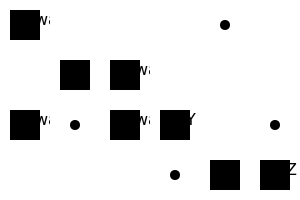

In [2]:
using Quac

n = 4
depth = 2

# Define the quantum circuit
circ = Circuit(n)
gates = [Swap, CX, CY, CZ, CRx, CRy, CRz]
for i in 1:n
    for j in 1:depth
        # We want to apply some entangling gates
        k = rand(1:n)
        gate = gates[rand(1:length(gates))]
        if k != i
            push!(circ, gate(k, i))
        end
    end
end

circ

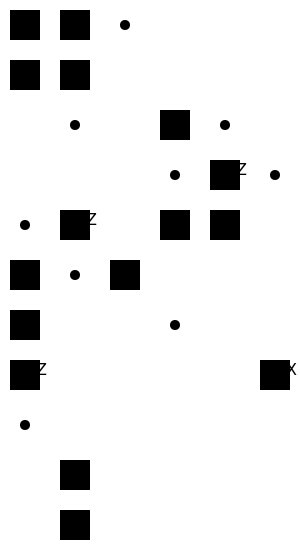

In [3]:
using Quac

# Set the number of qubits and the depth of the circuit
n = 8
depth = 2

# Define the quantum circuit
circ = Circuit(n)
single_qubit_gates = [X, Y, Z, H]  # List of possible single-qubit gates
two_qubit_gates = [Swap, CX, CY, CZ, CRx, CRy, CRz]   # List of possible two-qubit gates

# Populate the circuit with a mix of single and two-qubit random gates
for layer in 1:depth
    for qubit in 1:n
        if rand() < 0.5
            # 50% chance to add a single-qubit gate
            gate = single_qubit_gates[rand(1:length(single_qubit_gates))]
            push!(circ, gate(qubit))  # Example angle π/4, modify as needed
        else
            # 50% chance to add a two-qubit gate
            partner = rand(setdiff(1:n, qubit))
            gate = two_qubit_gates[rand(1:length(two_qubit_gates))]
            push!(circ, gate(partner, qubit))
        end
    end
end

# Display the created circuit
circ

Now let's convert this circuit to a tensor network with `Tenet`

In [3]:
using Pkg
Pkg.add("CairoMakie") # For plotting
Pkg.add("GraphMakie") # For plotting

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


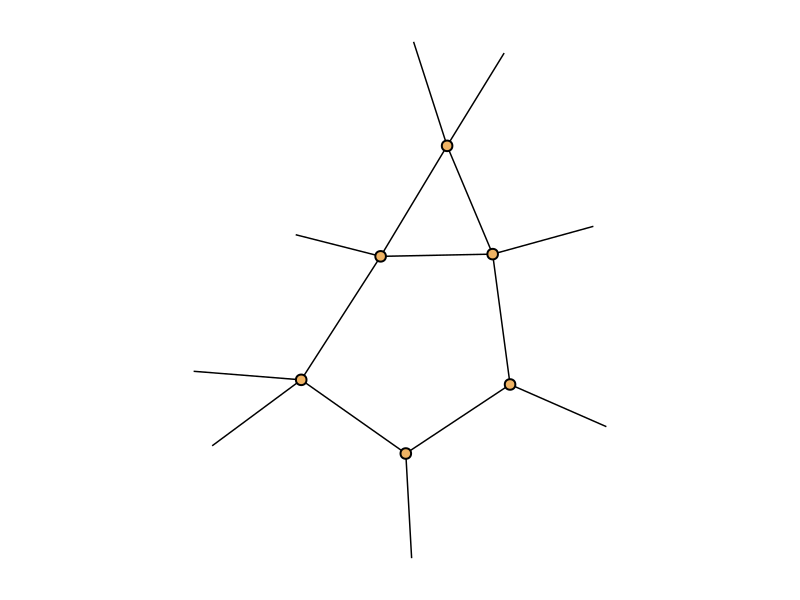

In [4]:
using CairoMakie
using GraphMakie
using Tenet
using Qrochet

qtn = Quantum(circ)
tn = TensorNetwork(qtn)
plot(tn)

We get a `Tensor Network` object that contains the tensor network representation of the circuit. It has $2N$ open indices, where $N$ is the number of qubits in the circuit, since we need to connect the input and output  qubits of the circuit to the tensor network.

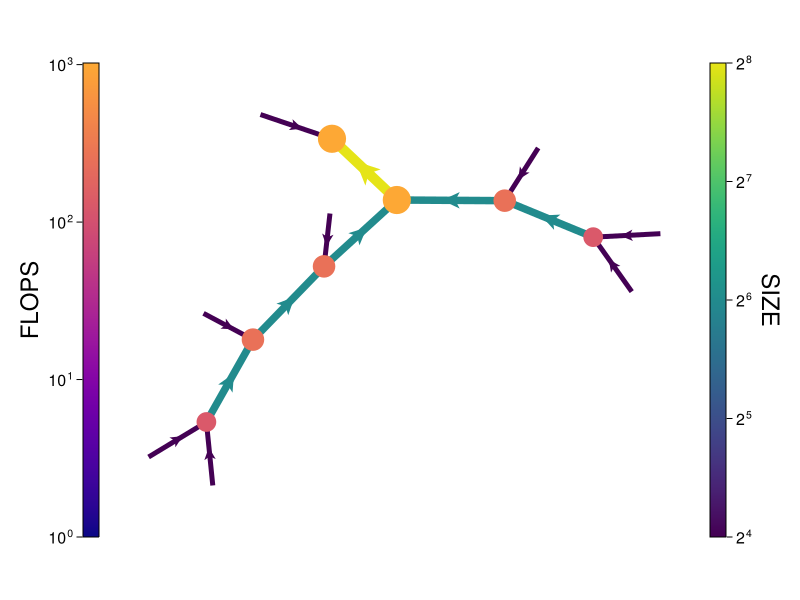

In [5]:
using EinExprs

path = einexpr(tn, optimizer=Greedy())
plot(path)

In [7]:
total_flops = mapreduce(flops, +, Branches(path))
max_dims = maximum(ndims, Branches(path))

total_flops, max_dims

(134560, 16)

Let's contract the circuit:

In [8]:
# tn = TensorNetwork(qtn)

ψᵢₙ = Product(fill([1, 0], n))
ψₒᵤₜ = Product(fill([1, 0], n))

Qrochet.@reindex! inputs(qtn) => outputs(ψᵢₙ)
Qrochet.@reindex! outputs(qtn) => outputs(ψₒᵤₜ)

contract(merge(TensorNetwork(ψᵢₙ), TensorNetwork(qtn), TensorNetwork(ψₒᵤₜ)))

# tn = view(tn, [i => 1 for i in inds(tn, set=:open)]...)

# c = contract(tn)

0-dimensional Tensor{ComplexF64, 0, Array{ComplexF64, 0}}:
0.0 + 0.0im

In [9]:
new_tn = merge(TensorNetwork(ψᵢₙ), TensorNetwork(qtn), TensorNetwork(ψₒᵤₜ))

path = einexpr(new_tn, optimizer=Greedy())

total_flops = mapreduce(flops, +, Branches(path))
max_dims = maximum(ndims, Branches(path))

total_flops, max_dims

(406, 4)

Let's create a more complex circuit

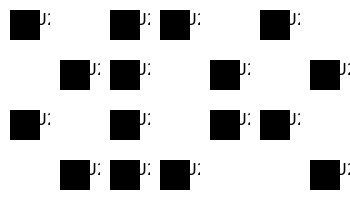

In [10]:
n = 4
depth = 4

Array{T, M}(op::SU{N}) where {T, N, M} = (@assert M == 2 * N "M must be exactly 2 * N"; Array{T, 2N}(reshape(Matrix{T}(op), fill(2, 2N)...)))
circ = Quac.Algorithms.QuantumVolume(n, depth)

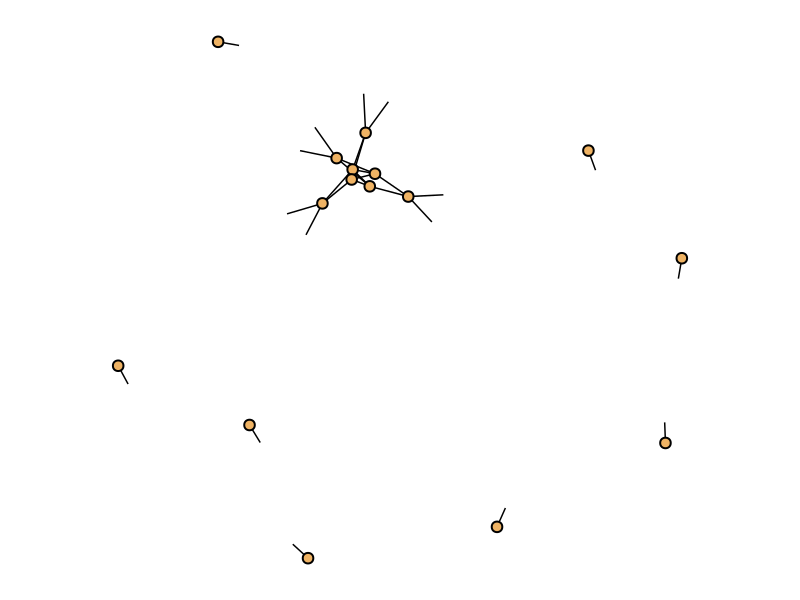

In [11]:
qtn = Quantum(circ)

ψᵢₙ = Product(fill([1, 0], n))
ψₒᵤₜ = Product(fill([1, 0], n))

tn = merge(TensorNetwork(ψᵢₙ), TensorNetwork(qtn), TensorNetwork(ψₒᵤₜ))

plot(tn)

In [21]:
path = einexpr(tn, optimizer=Greedy())

total_flops = mapreduce(flops, +, Branches(path))
max_dims = maximum(ndims, Branches(path))

total_flops, max_dims

(72192, 16)

Much larger circuit!! We need an approximation! We will use MPS

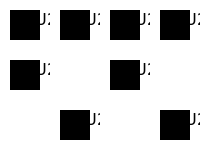

In [6]:
n = 3
depth = 4

Array{T, M}(op::SU{N}) where {T, N, M} = (@assert M == 2 * N "M must be exactly 2 * N"; Array{T, 2N}(reshape(Matrix{T}(op), fill(2, 2N)...)))
circ = Quac.Algorithms.QuantumVolume(n, depth)

In [7]:

for i in 1:lanes(circ)
    for gate in circ.lanes[i]
        if isa(gate, Quac.Element{Gate})
            println("gate type:",gate.data.operator, " qubits:", gate.data.lanes)
        end
    end
end

gate type:SU{2}(ComplexF64[-0.5015479378587728 - 0.29010053562485527im 0.3891675703732655 + 0.09145498146280372im -0.015217047104142022 - 0.10543888085837247im 0.7017334632230107 + 0.026403868447556655im; -0.4079873930564329 - 0.15690134582227186im -0.7451996288812706 - 0.1834049789382923im 0.442478276654676 - 0.13891298585556117im 0.06965167302676781 - 0.005760477064398514im; -0.33847436966892935 - 0.01409309767841821im -0.024303522562402702 - 0.37752566455284076im -0.5899941970408751 - 0.39383574923756454im -0.2723059307482194 + 0.4059186214378038im; -0.41094265656951956 - 0.43541040264627756im -0.04219704900269035 + 0.3260794930714409im -0.2667204586239918 + 0.44634928919194156im -0.4204744426093159 - 0.29371625701409554im]) qubits:(1, 2)
gate type:SU{2}(ComplexF64[-0.3676170706674682 - 0.2618799593826861im 0.13135049582238273 - 0.35553750953068847im 0.651814146934 + 0.3282590934512408im 0.2544686488842391 - 0.23504615493520303im; -0.07788094341179795 - 0.00577927378175855im -0.0751

start_qubit:1 expected_qubits:1:2
start_qubit:2 expected_qubits:2:3
start_qubit:1 expected_qubits:1:2
start_qubit:3 expected_qubits:3:4


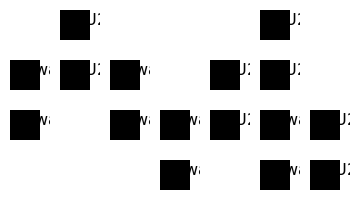

In [159]:
using Quac

n = 4
circ = Quac.Algorithms.QuantumVolume(n, 2)

function reorder_circuit_for_contiguity(original_circ::Circuit)
    new_circ = Circuit(lanes(original_circ))  # Initialize a circuit with the same number of qubits
    total_qubits = lanes(original_circ)

    # Initialize positions for all qubits in the circuit
    current_positions = Dict(i => i for i in 1:total_qubits)
    for gate in original_circ  # Ensure you're iterating over gates correctly
        # println("Original gate:", gate)
        if isa(gate, Quac.Gate)
            qubits = collect(sort(gate.lanes|> collect))

            # Ensure all qubits are in contiguous positions
            start_qubit = qubits[1]
            expected_qubits = start_qubit:(start_qubit + length(qubits) - 1)

            println("start_qubit:", start_qubit, " expected_qubits:", expected_qubits)

            for (idx, actual_qubit) in enumerate(qubits)
                expected_qubit = expected_qubits[idx]
                if current_positions[actual_qubit] != expected_qubit
                    # Swap is needed
                    swap_q1 = current_positions[actual_qubit]
                    swap_q2 = expected_qubit
                    if swap_q1 > swap_q2
                        swap_q1, swap_q2 = swap_q2, swap_q1
                    end

                    # Iteratively add Swap gates that are contiguous
                    for q in swap_q1:(swap_q2 - 1)
                        push!(new_circ, Swap(q, q + 1))
                        # println("Adding Swap between $q and $(q + 1)")

                        # Perform the swap in the current position tracking
                        current_positions[q], current_positions[q + 1] =
                            current_positions[q + 1], current_positions[q]
                    end
                    # push!(new_circ, Swap(swap_q1, swap_q2))
                    # println("Adding Swap between $swap_q1 and $swap_q2")

                    # # Perform the swap in the current position tracking
                    # current_positions[swap_q1], current_positions[swap_q2] =
                    #     current_positions[swap_q2], current_positions[swap_q1]
                end
            end

            # Add the actual gate with correctly ordered qubits
            new_qubits = [current_positions[q] for q in qubits]
            # println("New qubits for gate:", new_qubits)
            modified_gate = typeof(gate.operator)(new_qubits...; matrix=gate.operator.matrix)
            push!(new_circ, modified_gate)
            # println("Adding modified gate with qubits $(new_qubits)")
        end
    end
    
    return new_circ
end


circ2 = reorder_circuit_for_contiguity(deepcopy(circ))
circ2

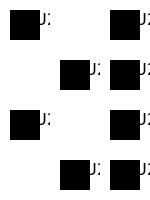

In [160]:
circ

In [161]:
ψᵢₙ = Product(fill([1, 0], n))
ψₒᵤₜ = Product(fill([1, 0], n))

qtn = Quantum(circ2)

Qrochet.@reindex! inputs(qtn) => outputs(ψᵢₙ)
Qrochet.@reindex! outputs(qtn) => outputs(ψₒᵤₜ)

contract(merge(TensorNetwork(ψᵢₙ), TensorNetwork(qtn), TensorNetwork(ψₒᵤₜ)))

0-dimensional Tensor{ComplexF64, 0, Array{ComplexF64, 0}}:
-0.019291346847351135 + 0.16631653866231402im

In [162]:
ψᵢₙ = Product(fill([1, 0], n))
ψₒᵤₜ = Product(fill([1, 0], n))

qtn = Quantum(circ)

Qrochet.@reindex! inputs(qtn) => outputs(ψᵢₙ)
Qrochet.@reindex! outputs(qtn) => outputs(ψₒᵤₜ)

contract(merge(TensorNetwork(ψᵢₙ), TensorNetwork(qtn), TensorNetwork(ψₒᵤₜ)))

0-dimensional Tensor{ComplexF64, 0, Array{ComplexF64, 0}}:
-0.008867178734392758 + 0.2386427655998622im

In [183]:
ψᵢₙ = convert(Chain, Product(fill([1, 0], n)))
ψₒᵤₜ = convert(Chain, Product(fill([1, 0], n)))

canonize!(ψᵢₙ)
# ψₒᵤₜ = convert(Chain, Product(fill([1, 0], n)))

# Apply gates using `evolve!` function

for gate in circ2
    evolve!(ψᵢₙ, Qrochet.Dense(gate); maxdim=10, iscanonical=true)
end

Qrochet.@reindex! outputs(ψᵢₙ) => outputs(ψₒᵤₜ)

contract(merge(TensorNetwork(ψᵢₙ), TensorNetwork(ψₒᵤₜ)))


0-dimensional Tensor{ComplexF64, 0, Array{ComplexF64, 0}}:
-0.3413627071908595 - 0.04608833134114043im

test

In [28]:
using Quac

# Set the number of qubits and the depth of the circuit
n = 80
depth = 30

# Define the quantum circuit
circ = Circuit(n)
single_qubit_gates = [X, Y, Z, H]  # List of possible single-qubit gates
two_qubit_gates = [Rxx, Ryy, Rzz]   # List of possible two-qubit gates

# Populate the circuit with a mix of single and two-qubit random gates
for layer in 1:depth
    for qubit in 1:n
        if rand() < 0.2
            # 50% chance to add a single-qubit gate
            gate = single_qubit_gates[rand(1:length(single_qubit_gates))]
            push!(circ, gate(qubit))
        else
            # 50% chance to add a two-qubit gate
            if qubit > 1
                partner = qubit - 1
            else
                partner = qubit + 1
            end
            gate = two_qubit_gates[rand(1:length(two_qubit_gates))]
            push!(circ, gate(partner, qubit))
        end
    end
end

# Display the created circuit
# circ

In [29]:
using EinExprs
using Qrochet
using Tenet

qtn = Quantum(circ)

ψᵢₙ = Product(fill([1, 0], n))
ψₒᵤₜ = Product(fill([1, 0], n))

Qrochet.@reindex! inputs(qtn) => outputs(ψᵢₙ)
Qrochet.@reindex! outputs(qtn) => outputs(ψₒᵤₜ)

tn = merge(TensorNetwork(ψᵢₙ), TensorNetwork(qtn), TensorNetwork(ψₒᵤₜ))

path = einexpr(tn, optimizer=Greedy())

total_flops = mapreduce(flops, +, Branches(path))
max_dims = maximum(ndims, Branches(path))

total_flops, max_dims

(120324439163356, 33)

In [30]:
using CairoMakie

plot(path)

InterruptException: InterruptException:

In [12]:
# using KaHyPar

# qtn = Quantum(circ)

# ψᵢₙ = Product(fill([1, 0], n))
# ψₒᵤₜ = Product(fill([1, 0], n))

# tn = merge(TensorNetwork(ψᵢₙ), TensorNetwork(qtn), TensorNetwork(ψₒᵤₜ))

# path = einexpr(tn, optimizer=HyPar())

# total_flops = mapreduce(flops, +, Branches(path))
# max_dims = maximum(ndims, Branches(path))

# total_flops, max_dims

In [26]:
qtn = Quantum(circ)

ψᵢₙ = Product(fill([1, 0], n))
ψₒᵤₜ = Product(fill([1, 0], n))

Qrochet.@reindex! inputs(qtn) => outputs(ψᵢₙ)
Qrochet.@reindex! outputs(qtn) => outputs(ψₒᵤₜ)

tn = merge(TensorNetwork(ψᵢₙ), TensorNetwork(qtn), TensorNetwork(ψₒᵤₜ))

contract(tn)

0-dimensional Tensor{ComplexF64, 0, Array{ComplexF64, 0}}:
0.0 + 0.0im

In [34]:
ψᵢₙ = convert(Chain, Product(fill([1, 0], n)))
ψₒᵤₜ = convert(Chain, Product(fill([1, 0], n)))

canonize!(ψᵢₙ)

# Apply gates using `evolve!` function
for gate in circ
    evolve!(ψᵢₙ, Qrochet.Dense(gate); maxdim=16, iscanonical=true)
end

Qrochet.@reindex! outputs(ψᵢₙ) => outputs(ψₒᵤₜ)

contract(merge(TensorNetwork(ψᵢₙ), TensorNetwork(ψₒᵤₜ)))


0-dimensional Tensor{ComplexF64, 0, Array{ComplexF64, 0}}:
0.0 + 0.0im

### Transfer Ising Model

$H = -\sum_{\braket{i,j}} \sigma_{X}^{(i)} \sigma_{X}^{(j)} + \lambda \sum_i \sigma_Z^{(i)}$

In [70]:
observables = Dense.([Z(5)])


1-element Vector{Dense}:
 Dense (inputs=1, outputs=1)